In [53]:
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

from typing import List

In [54]:
def read_prompts(target_experiment: str, tasks: List[str]):
    results = pd.DataFrame()
    for logging_dir in Path(f"../logs/{target_experiment}").rglob("*.csv"):
        if "best_scores" in str(logging_dir):
            continue

        result = pd.read_csv(logging_dir)

        logging_dir = str(logging_dir)

        logging_dir = logging_dir.replace(f"..\\logs\\{target_experiment}\\", "")
        logging_dir = logging_dir.replace(".csv", "")

        task_name, optimizer, meta_llm, evaluation_llm, random_seed = logging_dir.split("_")

        metainformation = pd.DataFrame(
            {
                "task": [task_name] * len(result),
                "optimizer": [optimizer] * len(result),
                "meta_llm": [meta_llm] * len(result),
                "evaluation_llm": [evaluation_llm] * len(result),
                "random_seed": [random_seed] * len(result),
            }
        )

        result = pd.concat([result, metainformation], axis=1)

        results = pd.concat([result, results], axis=0)

    return results


def read_best_scores(target_experiment: str):
    return pd.read_csv(f"../logs/{target_experiment}/best_scores.csv")

In [55]:
df_train = read_prompts(f"experiment", "")
df_test = read_best_scores(f"experiment")

df_train.random_seed = df_train.random_seed.astype(int)
df_test.random_seed = df_test.random_seed.astype(int)

In [56]:
df_train["evaluation_llm"] = df_train["evaluation_llm"].str.replace("\\", "/", regex=False)
df_train["meta_llm"] = df_train["meta_llm"].str.replace("\\", "/", regex=False)

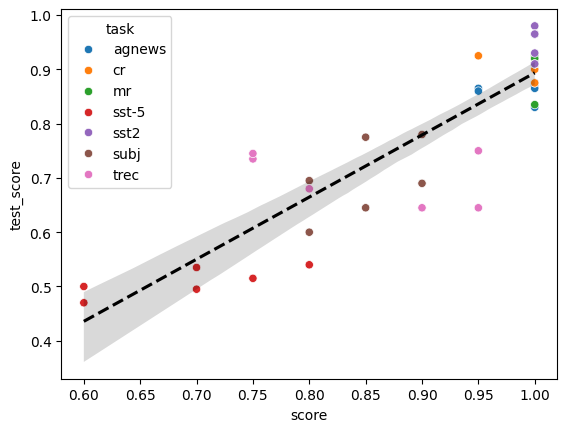

,score,test_score
score,1.000000,0.891781
test_score,0.891781,1.000000


In [57]:
evaluation_llm = meta_llm = "meta-llama/Meta-Llama-3-70B-Instruct"

group_cols = ["task", "optimizer", "meta_llm", "evaluation_llm", "random_seed"]

df1 = df_train[(df_train["meta_llm"] == meta_llm) & (df_train["evaluation_llm"] == evaluation_llm)]

# find prompt which got the best score first, per seed
df1 = df1.sort_values("score", ascending=False)  #
df1 = df1.groupby(group_cols).first()

df2 = df_test[
    #     (df_test["task"] == task)
    (df_test["meta_llm"] == meta_llm)
    & (df_test["evaluation_llm"] == evaluation_llm)
]

df2 = df2.set_index(group_cols)

df1 = df1[["score"]]
df1.loc[:, "test_score"] = df2.loc[df1.index, ["test_score"]]

sns.scatterplot(data=df1, x="score", y="test_score", hue="task")
# trendline black with dashed
sns.regplot(data=df1, x="score", y="test_score", scatter=False, color="black", line_kws={"linestyle": "dashed"})
plt.show()

df1.corr()

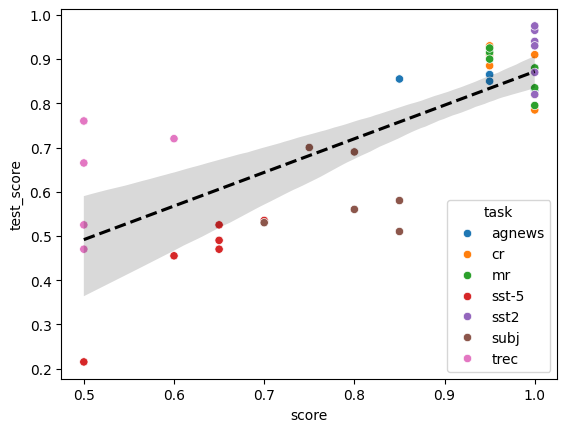

,score,test_score
score,1.000000,0.769682
test_score,0.769682,1.000000


In [58]:
evaluation_llm = meta_llm = "meta-llama/Meta-Llama-3-8B-Instruct"

group_cols = ["task", "optimizer", "meta_llm", "evaluation_llm", "random_seed"]

df1 = df_train[(df_train["meta_llm"] == meta_llm) & (df_train["evaluation_llm"] == evaluation_llm)]

# find prompt which got the best score first, per seed
df1 = df1.sort_values("score", ascending=False)  #
df1 = df1.groupby(group_cols).first()

df2 = df_test[
    #     (df_test["task"] == task)
    (df_test["meta_llm"] == meta_llm)
    & (df_test["evaluation_llm"] == evaluation_llm)
]

df2 = df2.set_index(group_cols)

df1 = df1[["score"]]
df1.loc[:, "test_score"] = df2.loc[df1.index, ["test_score"]]

sns.scatterplot(data=df1, x="score", y="test_score", hue="task")
# trendline black with dashed
sns.regplot(data=df1, x="score", y="test_score", scatter=False, color="black", line_kws={"linestyle": "dashed"})
plt.show()

df1.corr()

In [59]:
group_cols = ["task", "optimizer", "meta_llm", "evaluation_llm", "random_seed"]

df1 = df_train

# find prompt which got the best score first, per seed
df1 = df1.sort_values("score", ascending=False)  #
df1 = df1.groupby(group_cols).first()

df2 = df_test

df2 = df2.set_index(group_cols)

df1 = df1[["score"]]
df1.loc[:, "test_score"] = df2.loc[df1.index, ["test_score"]]
df1 = df1.reset_index()

In [60]:
df1.loc[df1["meta_llm"] == "meta-llama/Meta-Llama-3-70B-Instruct", "meta_llm"] = "Llama-70B"
df1.loc[df1["evaluation_llm"] == "meta-llama/Meta-Llama-3-70B-Instruct", "evaluation_llm"] = "Llama-70B"
df1.loc[df1["meta_llm"] == "meta-llama/Meta-Llama-3-8B-Instruct", "meta_llm"] = "Llama-8B"
df1.loc[df1["evaluation_llm"] == "meta-llama/Meta-Llama-3-8B-Instruct", "evaluation_llm"] = "Llama-8B"
df1.loc[df1["optimizer"] == "evopromptde", "optimizer"] = "DE"
df1.loc[df1["optimizer"] == "evopromptga", "optimizer"] = "GA"

In [61]:
df1["score"] *= 100
df1["test_score"] *= 100

In [62]:
df1["diff"] = df1["test_score"] - df1["score"]
df1 = df1.rename(columns={"score": "train_score"})

In [63]:
diff_df = (
    df1.groupby(["task", "optimizer", "meta_llm", "evaluation_llm"])
    .mean()
    .reset_index()
    .drop(["random_seed", "evaluation_llm"], axis=1)
    .round(2)
)

In [71]:
diff_df.groupby(["meta_llm", "optimizer"]).mean(numeric_only=True).round(2)

train_score  test_score   diff
meta_llm  optimizer                                
Llama-70B DE               89.76       79.74 -10.02
          GA               92.14       78.26 -13.88
Llama-8B  DE               81.67       74.52  -7.14
          GA               85.00       74.50 -10.50